In [1]:
import numpy as np
import h5py
import pylab as pl
import arrayfire as af
from scipy.integrate import odeint
import scipy.fftpack as ff
from scipy import interpolate
import arrayfire as af

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
def periodic_particles(positions_x, length_domain_x):
    '''
    function periodic_particles(positions_x, length_domain_x)
    -----------------------------------------------------------------------
    Input variables: positions_x and length_domain_x

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code. 
        It contains the positions of particles.

        length_domain_x: This is the length of the domain. The domain is assumed to be from x = 0 
        to x = length_domain_x 

    -----------------------------------------------------------------------    
    returns: positions_x
        This function returns the modified positions_x such that particle previously gone outside the domain 
        through the left boundary enter via the right boundary and vice versa.
        In other words, the function implements periodic boundary conditions for the particles. 

    '''
    
    # Arrayfire implementation
    # Determine indices of particles which have gone outside the domain
    # through right boundary
    outside_domain_right       = af.algorithm.where(positions_x >= length_domain_x)
    
    # Determine indices of particles which have gone outside the domain
    # through left boundary         
    outside_domain_left        = af.algorithm.where(positions_x <  0  )
    

    if outside_domain_right.elements() > 0:
        
        # Apply periodic boundary conditions

        positions_x[outside_domain_right] = positions_x[outside_domain_right] - length_domain_x


    if outside_domain_left.elements() > 0:
        
        # Apply periodic boundary conditions
        
        positions_x[outside_domain_left]  = positions_x[outside_domain_left] + length_domain_x

        
        
    af.eval(positions_x)
    
    return positions_x


In [4]:
def periodic_rho(rho, ghost_cells):
    # Applying periodic BC's for charge depostions from last and first zone since 
    # first and the last x_grid point are the same point according to periodic BC's
    # Since first and last point are the same, charge being deposited on the last grid point
    # must also be deposited on the first grid point
    
    len_x = (rho).elements()
    
    rho_electrons[ghost_cells]  = rho_electrons[ghost_cells] + rho_electrons[-1 - ghost_cells]
    rho_electrons[-1 - ghost_cells] = rho_electrons[ghost_cells].copy()
    
    rho_electrons[-2 - ghost_cells] = rho_electrons[ghost_cells - 1] + rho_electrons[-2 - ghost_cells]
    rho_electrons[ghost_cells + 1]= rho_electrons[ghost_cells + 1] + rho_electrons[-ghost_cells]
    
    # assigning values to the ghost nodes
    rho[0 : ghost_cells]            = rho[len_x -1 - 2 * ghost_cells: len_x -1 - 1 * ghost_cells]
    rho[len_x - ghost_cells : len_x] = rho[ghost_cells + 1: 2 * ghost_cells + 1]
    
    
    return rho

In [5]:
def periodic_field(field, ghost_cells):
    # Applying periodic BC's for charge depostions from last and first zone since 
    # first and the last x_grid point are the same point according to periodic BC's
    # Since first and last point are the same, charge being deposited on the last grid point
    # must also be deposited on the first grid point
    
    len_x = len(field)
    
    # assigning values to the ghost nodes
    field[0 : ghost_cells]             = field[len_x -1 - 2 * ghost_cells: len_x -1 - 1 * ghost_cells]
    field[len_x - ghost_cells : len_x] = field[ghost_cells + 1: 2 * ghost_cells + 1]
    
    
    return field

## Triangular Shaped Cloud(TSC) charge deposition: 
\begin{align}
\implies  \rho(\mathbf{x_{i}}, t) &= \frac{1 }{\Delta x}w_{p}q \sum_{p = 1}^{N} b_{2}\left(\frac{x_{p} - \mathbf{x_{i}}}{\Delta x}\right) 
\end{align}

In [6]:
# b1 charge depositor
def TSC_charge_deposition(charge_electron, number_of_electrons, positions_x,\
                  x_grid, ghost_cells,length_domain_x, dx):
    '''
    function cloud_charge_deposition(charge, zone_x, frac_x, x_grid, dx)
    -----------------------------------------------------------------------  
    Input variables: charge, zone_x, frac_x, x_grid, dx

        charge: This is a scalar denoting the charge of the macro particle in the PIC code.

        zone_x: This is an array of size (number of electrons/macro particles) containing the indices 
        of the left corners of the grid cells containing the respective particles

        frac_x: This is an array of size (number of electrons/macro particles) containing the fractional values of 
        the positions of particles in their respective grid cells. This is used for linear interpolation

        x_grid: This is an array denoting the position grid chosen in the PIC simulation

        dx: This is the distance between any two consecutive grid nodes of the position grid.

    -----------------------------------------------------------------------  
    returns: rho
         rho: This is an array containing the charges deposited at the density grid nodes.
    '''

    base_indices = af.data.constant(0, positions_x.elements(), dtype=af.Dtype.u32)


    x_zone = (((af.abs(positions_x - af.sum(x_grid[0])))/dx).as_type(af.Dtype.u32))

    temp = af.where(af.abs(positions_x-x_grid[x_zone])<af.abs(positions_x-x_grid[x_zone + 1]))

    if(temp.elements()>0):
        base_indices[temp] = x_zone[temp]

    temp = af.where(af.abs(positions_x - x_grid[x_zone])>=af.abs(positions_x-x_grid[x_zone + 1]))

    if(temp.elements()>0):
        base_indices[temp] = (x_zone[temp] + 1).as_type(af.Dtype.u32)    

    base_indices_minus = (base_indices - 1).as_type(af.Dtype.u32)    
    base_indices_plus  = (base_indices + 1).as_type(af.Dtype.u32)    


    index_list = af.join(0, base_indices_minus, base_indices, base_indices_plus)

    positions_x_3x        = af.join(0, positions_x, positions_x, positions_x)

    distance_nodes = x_grid[index_list]


    W = 0 * positions_x_3x.copy()

    temp = af.where(af.abs(distance_nodes - positions_x_3x) < dx/2 )

    if(temp.elements()>0):
        W[temp] = 0.75 - (af.abs(distance_nodes[temp] - positions_x_3x[temp])/dx)**2

    temp = af.where((af.abs(distance_nodes - positions_x_3x) >= dx/2 )\
                     * (af.abs(distance_nodes - positions_x_3x) < (1.5 * dx) )\
                   )

    if(temp.elements()>0):
        W[temp] = 0.5 * (1.5 - (af.abs(distance_nodes[temp] - positions_x_3x[temp])/dx))**2

    charges = (charge_electron * W)/dx

    # Depositing currents using numpy histogram
    input_indices      = index_list
    elements           = x_grid.elements()

    rho, temp = np.histogram(input_indices, bins=elements, range=(0, elements),weights=charges)

    rho = af.to_array(rho)

    af.eval(rho)


    return rho

The charge density is computed using the normalization factor $A$ given by :
\begin{align}
f_{pic} &= f_{a}  \\
\implies A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int f_{pic}\;dv\;dx}  \\
A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int\sum_{p=1}^{N_{m}} w_{p}S(x, x_{p})S(v, v_{x,p})\;dv\;dx} \\
A &= \frac{\int \int f_{a}\;dv\;dx}{N_{m} * w_{p}}
\end{align}
Background ion density is added to the computed charge density array:
\begin{align}
\int_{x_{i - \frac{1}{2}}}^{x_{i + \frac{1}{2}}} S(x, x_{p})dx &= b_{0+1}(\frac{\mathbf{x_{i}}- x_{p}}{\Delta x}) \\
\implies  \rho(\mathbf{x_{i}}, t) &= \frac{1 }{\Delta x}Aw_{p}q \sum_{p = 1}^{N} b_{1}\left(\frac{x_{p} - \mathbf{x_{i}}}{\Delta x}\right) + \rho_{ions}
\end{align}

In [7]:
def norm_background_ions(rho_electrons, number_of_electrons, w_p, charge_electron):
    '''
    function norm_background_ions(rho_electrons, number_of_electrons)
    -----------------------------------------------------------------------  
    Input variables: rho_electrons, number_of_electrons
        rho_electrons: This is an array containing the charges deposited at the density grid nodes.

        number_of_electrons: A scalar denoting the number of macro particles/electrons taken in the simulation
    -----------------------------------------------------------------------      
    returns: rho_normalized
        This function returns a array denoting the normalized charge density throughout the domain containing
        the contribution due background ions

    '''
    A                        = 1/(number_of_electrons * w_p)
    rho_electrons_normalized = A*rho_electrons
    
    # Adding background ion density, and ensuring charge neutrality
    
    rho_normalized           = rho_electrons_normalized - charge_electron
    
    return rho_normalized



\begin{align}
\hat{V}(k) &= \int_{0}^{1} potential(x)e^{-2\pi\;i\;k\;x}dx \\ \\
potential(x) &= \frac{1}{Npoints}\int_{0}^{1} \hat{potential}(k)e^{+2\pi\;i\;k\;x}dk \\ \\
\hat{potential}(k) &= \frac{1}{4\pi^{2}\;k^2}\hat{\rho(k)} \\ \\
\hat{E}(k) &= -i(2\pi\;k)\hat{potential}(k)
\end{align}

In [8]:
# FFT solver :
def fft_poisson(rho, dx):
    '''
    function fft_poisson(rho, dx)
    -----------------------------------------------------------------------  
    Input variables: rho, dx

        rho: This is an array containing the charges deposited at the density grid nodes.

        dx: This is the distance between any two consecutive grid nodes of the position grid.

    -----------------------------------------------------------------------  
    returns: potential, E

        potential: This is an array containing the potential values across the domain

        E: This is an array containing the electric field values across the domain.

    '''
    
    rho_temp      = rho[:-1]
    k_x           = ff.fftfreq(len(rho_temp), d = dx)
    rho_hat       = ff.fft(rho_temp)
    potential_hat = np.zeros(len(rho_temp))
    
    potential_hat[1:] =  (1/(4 * np.pi**2 * k_x[1:]**2)) * rho_hat[1:]
    potential_hat[0]  =  0
    
    E_hat =  -1j * 2 * np.pi * k_x * potential_hat
    
    potential = ff.ifft(potential_hat)
    potential = np.append(potential,potential[0])
    potential = (potential.real).astype(np.double)
    
    E = ff.ifft(E_hat)
    E = np.append(E,E[0])
    E = (E.real).astype(np.double)
    
    return potential, E

In [9]:
def set_up_perturbation(positions_x, number_particles, N_divisions,\
                        amplitude , k_x, length_domain_x, dx\
                       ):
    '''
    function set_up_perturbation(positions_x, number_particles, N_divisions,\
                                 amplitude , k, length_domain_x\
                                ):
    -----------------------------------------------------------------------  
    Input variables: positions_x, number_particles, N_divisions, amplitude, k,length_domain_x

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles.

        number_particles: The number of electrons /macro particles

        N_divisions: The number of divisions considered for placing the macro particles

        amplitude: This is the amplitude of the density perturbation

        k_x: The is the wave number of the cosine density pertubation

        length_domain_x: This is the length of the domain in x direction

    -----------------------------------------------------------------------      
    returns: positions_x
        This function returns a array positions_x such that there is a cosine density perturbation 
        of the given amplitude

    '''
    # There might be a few particles left out during execution of function and the statement
    # below randomizes those positions
    positions_x = length_domain_x * np.random.rand(number_particles)

    particles_till_x_i = 0

    # Looping over grid cells in the domain
    for i in range(N_divisions):

        # Average number of particles present between two consecutive grid nodes
        average_particles_x_i_to_i_plus_one = (number_particles/(length_domain_x/dx))

        # Amplitude in the current grid cell used to compute number of particles in the
        # current grid cell
        temp_amplitude = amplitude * np.cos(k_x * (i + 0.5) * dx / length_domain_x)

        # Computing number of particles in the current grid cell
        number_particles_x_i_to_i_plus_one = int(average_particles_x_i_to_i_plus_one \
                                                 * (1 + temp_amplitude)\
                                                )

        # Assigining these number of particles their respective positions in the current grid cell
        positions_x[particles_till_x_i\
                    :particles_till_x_i\
                    + number_particles_x_i_to_i_plus_one \
                   ] \
                            = i * dx \
                              + dx * np.random.rand(number_particles_x_i_to_i_plus_one)
        
        # keeping track of the number of particles that have been assigned positions
        particles_till_x_i += number_particles_x_i_to_i_plus_one

    return positions_x

In [10]:
def indices_and_currents_TSC(charge_electron, positions_x, dt, x_grid, dx, ghost_cells):
    
    positions_x_new     = positions_x + velocity_x * dt
    number_of_electrons = positions_x.elements()


    base_indices = af.data.constant(0, positions_x.elements(), dtype=af.Dtype.u32)
    Jx           = af.data.constant(0, positions_x.elements(), 5, dtype=af.Dtype.f64)


    x_zone = (((af.abs(positions_x - af.sum(x_grid[0])))/dx).as_type(af.Dtype.u32))
    
    temp   = af.where(af.abs(positions_x-x_grid[x_zone])<af.abs(positions_x-x_grid[x_zone + 1]))

    if(temp.elements()>0):
        base_indices[temp] = x_zone[temp]

    temp = af.where(af.abs(positions_x - x_grid[x_zone])>=af.abs(positions_x-x_grid[x_zone + 1]))

    if(temp.elements()>0):
        base_indices[temp] = (x_zone[temp] + 1).as_type(af.Dtype.u32)

    S0 = af.data.constant(0, 5 * positions_x.elements(), dtype=af.Dtype.f64)
    S1 = S0.copy()

    base_indices_plus      = (base_indices + 1 ).as_type(af.Dtype.u32)
    base_indices_plus_two  = (base_indices + 2 ).as_type(af.Dtype.u32)

    base_indices_minus     = (base_indices - 1 ).as_type(af.Dtype.u32)
    base_indices_minus_two = (base_indices - 2 ).as_type(af.Dtype.u32)


    index_list_1 = af.join( 0, base_indices_minus_two, base_indices_minus,\
                          )
    index_list_2 = af.join( 0, base_indices, base_indices_plus,base_indices_plus_two\
                          )

    index_list   = af.join(0, index_list_1, index_list_2)


    # Computing S(base_indices - 1, base_indices, base_indices + 1)

    positions_x_5x = af.join(0, positions_x, positions_x, positions_x)

    positions_x_5x = af.join(0, positions_x_5x, positions_x, positions_x)


    positions_x_new_5x = af.join(0, positions_x_new, positions_x_new, positions_x_new)

    positions_x_new_5x = af.join(0, positions_x_new_5x, positions_x_new, positions_x_new)


    # Computing S0


    temp = af.where(af.abs(positions_x_5x - x_grid[index_list]) < dx/2)

    if(temp.elements()>0):

        S0[temp] = (0.75) - (af.abs(positions_x_5x[temp] - x_grid[index_list[temp]])/dx)**2

    temp = af.where((af.abs(positions_x_5x - x_grid[index_list]) >= 0.5 * dx)\
                     * (af.abs(positions_x_5x - x_grid[index_list]) < 1.5 * dx)\
                   )


    if(temp.elements()>0):

        S0[temp] = 0.5 * (3/2 - af.abs((positions_x_5x[temp] - x_grid[index_list[temp]])/dx) )**2


    # Computing S1


    temp = af.where(af.abs(positions_x_new_5x - x_grid[index_list]) < dx/2)

    if(temp.elements()>0):

        S1[temp] = (3/4) - (af.abs(positions_x_new_5x[temp] - x_grid[index_list[temp]])/dx)**2

    temp = af.where((af.abs(positions_x_new_5x - x_grid[index_list]) >= 0.5 * dx)\
                     * (af.abs(positions_x_new_5x - x_grid[index_list]) < 1.5 * dx)\
                   )


    if(temp.elements()>0):

        S1[temp] = 0.5 * (3/2 - af.abs((positions_x_new_5x[temp] - x_grid[index_list[temp]])/dx) )**2


    # Computing DS


    DS = S1 - S0

    W = af.data.moddims(DS, number_of_electrons, 5)


    # Computing weights

    Jx[:, 0] = -1 * charge_electron * (dx/dt) * W[:, 0].copy()


    Jx[:, 1] = Jx[:, 0] + (-1 * charge_electron * (dx/dt) * W[:, 1].copy()) 

    Jx[:, 2] = Jx[:, 1] + (-1 * charge_electron * (dx/dt) * W[:, 2].copy()) 

    Jx[:, 3] = Jx[:, 2] + (-1 * charge_electron * (dx/dt) * W[:, 3].copy()) 

    Jx[:, 4] = Jx[:, 3] + (-1 * charge_electron * (dx/dt) * W[:, 4].copy()) 

    Jx = (1/dx) * Jx


    # Flattening the current matrix
    currents = af.flat(Jx)


    af.eval(index_list)
    af.eval(currents)


    return index_list, currents


In [11]:
def Jx_Esirkepov( charge_electron, no_of_electrons, positions_x, velocity_x,\
                  x_grid, ghost_cells,length_domain_x, dx, dt\
                ):
    
    '''
    function Jx_Esirkepov( charge_electron, no_of_electrons, positions_x, velocity_x,\
                           x_grid, ghost_cells,length_domain_x, dx, dt\
                         )
    -----------------------------------------------------------------------  
    Input variables: Jx_staggered, number_of_electrons, w_p

        Jx_staggered: This is an array containing the currents deposited on staggered lattice.

        number_of_electrons: Number of macroparticles taken in the domain.
        
        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------  
    returns: Jx_staggered

        Jx_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''    
    # storing the number of elements in x_center_grid for current deposition
    elements = x_grid.elements()

    index_list, currents = indices_and_currents_TSC( charge_electron, positions_x, dt, x_grid, dx, ghost_cells)




    # Depositing currents using numpy histogram
    input_indices      = (index_list)
    Jx_staggered, temp = np.histogram(input_indices,\
                                      bins=elements,\
                                      range=(0, elements),\
                                      weights=currents\
                                     )



    Jx_staggered = af.to_array(Jx_staggered)
    
    af.eval(Jx_staggered)

    return Jx_staggered

The current density is computed using the normalization factor $A$ given by :
\begin{align}
f_{pic} &= f_{a}  \\
\implies A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int f_{pic}\;dv\;dx}  \\
A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int\sum_{p=1}^{N_{m}} w_{p}S(x, x_{p})S(v, v_{x,p})\;dv\;dx} \\
A &= \frac{\int \int f_{a}\;dv\;dx}{N_{m} * w_{p}}
\end{align}
Background ion density is added to the computed charge density array:
\begin{align}
\int_{x_{i - \frac{1}{2}}}^{x_{i + \frac{1}{2}}} S(x, x_{p})dx &= b_{0+1}(\frac{\mathbf{x_{i}}- x_{p}}{\Delta x}) \\
\implies  J(\mathbf{x_{i}}, t) &= \frac{1}{\Delta x} Aw_{p}\;q \sum_{p=1}^{N_{m}} v_{x,p}\;b_{1}(\mathbf{x_{i}}, x_{p})
\end{align}

In [12]:
def current_norm_BC(Jx_staggered, number_of_electrons, w_p):
    
    '''
    function current_norm_BC(Jx_staggered, number_of_electrons, w_p)
    -----------------------------------------------------------------------  
    Input variables: Jx_staggered, number_of_electrons, w_p

        Jx_staggered: This is an array containing the currents deposited on staggered lattice.

        number_of_electrons: Number of macroparticles taken in the domain.
        
        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------  
    returns: Jx_norm_centered

        Jx_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''       
    len_x = Jx_staggered.elements()
    
    # Normalizing the currents to be deposited
    A                  = 1/(number_of_electrons * w_p)
    
    Jx_norm_staggered  = A * Jx_staggered

    
    # assigning the current density to the boundary points for periodic boundary conditions
    Jx_norm_staggered[ghost_cells]  = Jx_norm_staggered[ghost_cells] + Jx_norm_staggered[-1 - ghost_cells]
    Jx_norm_staggered[-1 - ghost_cells] = Jx_norm_staggered[ghost_cells].copy()
    
    Jx_norm_staggered[-2 - ghost_cells] = Jx_norm_staggered[-2 - ghost_cells] + Jx_norm_staggered[ghost_cells - 1]

    Jx_norm_staggered[-3 - ghost_cells] = Jx_norm_staggered[-3 - ghost_cells] + Jx_norm_staggered[ghost_cells - 2] 
    
    Jx_norm_staggered[ghost_cells + 1] = Jx_norm_staggered[ghost_cells + 1] + Jx_norm_staggered[-ghost_cells] 

    Jx_norm_staggered[ghost_cells + 2] = Jx_norm_staggered[ghost_cells + 2] + Jx_norm_staggered[1-ghost_cells] 
    
    # Assigning ghost cell values
    Jx_norm_staggered[0 : ghost_cells]             = Jx_norm_staggered[len_x -1 - 2 * ghost_cells: len_x -1 - 1 * ghost_cells]
    Jx_norm_staggered[len_x - ghost_cells : len_x] = Jx_norm_staggered[ghost_cells + 1: 2 * ghost_cells + 1]
    
    af.eval(Jx_norm_staggered)
    
    return Jx_norm_staggered

Using Computational particles
\begin{align}
q_{p} = w_{p}q \\
m_{p} = w_{p}m \\
\end{align}
where $q_{p}$ and $m_{p} $is the charge of the macro particle and mass of the macro particle respectively

In [13]:
# Weighting factor w_p = number of electrons composing the macro particle
# Doesn't affect the the physics of the system (Coarse graining doesn't affect vlasov maxwell system)
# It should be kept such that the number density in the PIC code corresponds
# to the densities found in real plasmas
w_p             = 1

In [14]:
# Macro Particle parameters
k_boltzmann     = 1
mass_electron   = 1 * w_p
tempertature    = 1
charge_electron = -10 * w_p
charge_ion      = +10 * w_p

In [15]:
# Setting the length of the domain
length_domain_x = 1

In [16]:
# Setting number of particle in the domain
number_of_electrons = 4000000

In [17]:
# Initializing the positions and velocities of the particles
positions_x = length_domain_x * np.random.rand(number_of_electrons)

# setting the mean and standard deviation of the maxwell distribution
# Thermal/mean velocity of macro particles should correspond to 
# that of individual electrons in the plasma 
mu, sigma = 0, (k_boltzmann * tempertature / (mass_electron / w_p))

# Initializing the velocitites according to the maxwell distribution

velocity_x = np.random.normal(mu, sigma, number_of_electrons)

In [18]:
ghost_cells  = 2

In [19]:
# Divisions in x grid
divisions_domain_x = 100
dx = length_domain_x / divisions_domain_x
# initializing the x grid
x_grid = np.linspace(    0 - ghost_cells * dx,\
                         length_domain_x + ghost_cells * dx, \
                         divisions_domain_x + 1 + 2 * ghost_cells,\
                         endpoint=True,\
                         dtype = np.double\
                    )

# dx is the distance between consecutive grid nodes
x_right = x_grid + dx/2

In [20]:
# Setting the amplitude for perturbation
N_divisions         = divisions_domain_x
amplitude_perturbed = 0.5
k_x                 = 2 * np.pi

# Initializing the perturbation
positions_x = set_up_perturbation(    positions_x,\
                                      number_of_electrons,\
                                      N_divisions,\
                                      amplitude_perturbed,\
                                      k_x,\
                                      length_domain_x,\
                                      dx                                  
                                 )

In [21]:
# Plotting the initial density perturbation

position_grid   = np.linspace(0, 1, divisions_domain_x)
number_electrons_in_bins, b  = np.histogram(positions_x, bins=(divisions_domain_x),\
                               range=(0, length_domain_x)\
                              )

number_density     = (number_electrons_in_bins / (number_of_electrons / divisions_domain_x))

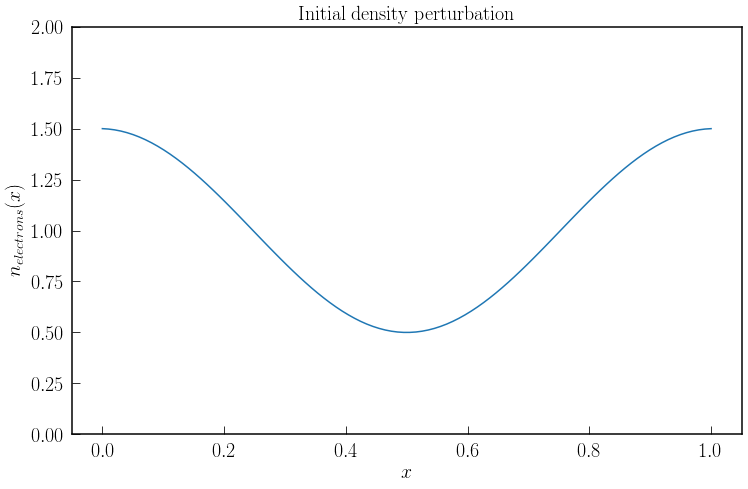

In [22]:
# Plotting the initial density perturbation
pl.plot(position_grid, number_density, label = r'$n$')
pl.title(r'$\mathrm{Initial\;density\;perturbation}$')
pl.xlabel('$x$')
pl.ylabel(r'$n_{electrons}(x)$')
pl.ylim(0.0,2.0)
pl.show()
pl.clf()

In [23]:
# Time parameters
start_time = 0

end_time   = 1

dt         = 0.002

time       = np.arange(    start_time,\
                           end_time + dt,\
                           dt,\
                           dtype = np.double\
                      )

In [24]:
# Some variables for storing data
Ex_max       = np.zeros(len(time), dtype = np.double)

In [25]:
# Plotting the initial conditions
# Charge deposition using TSC weighting scheme

rho_electrons  = TSC_charge_deposition(charge_electron, number_of_electrons,\
                                       af.to_array(positions_x), af.to_array(x_grid),\
                                       ghost_cells,length_domain_x, dx\
                                      )

rho_electrons = periodic_rho(rho_electrons, ghost_cells)
rho_initial = norm_background_ions(rho_electrons, number_of_electrons, w_p, charge_electron)

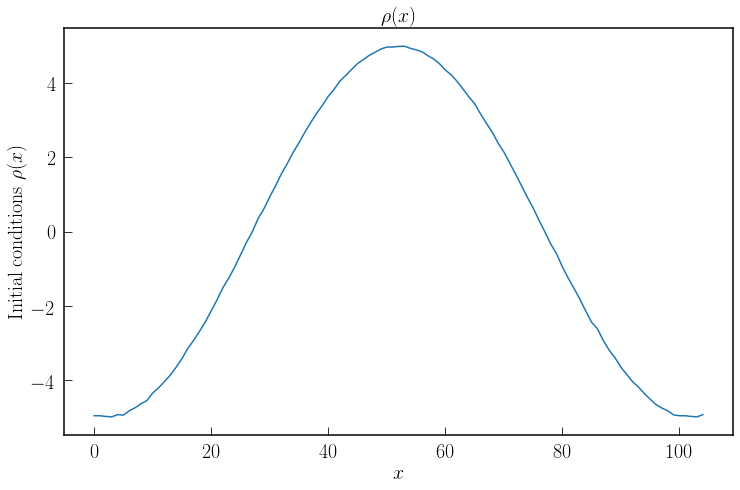

In [26]:
rho_initial = np.array(rho_initial)
# plotting intial rho in the system considering background ions
pl.plot(rho_initial)
pl.xlabel('$x$')
pl.ylabel(r'$\mathrm{Initial\;conditions}\;\rho(x)$')
pl.title(r'$\rho(x)$')
pl.show()
pl.clf()

In [27]:
# Computing initial potential and electric field
Ex_initial_centered = np.zeros(len(x_grid))
potential_initial, Ex_temp = fft_poisson(rho_initial[ghost_cells:-ghost_cells], dx)

Ex_initial_centered[ghost_cells:-ghost_cells] = Ex_temp[:]

Ex_initial_centered = periodic_field(Ex_initial_centered, ghost_cells)

/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


In [28]:
Divergence_E =   (np.roll(Ex_initial_centered, -1) - np.roll(Ex_initial_centered, 1)) / (2 * dx)

Divergence_E = periodic_field(Divergence_E, ghost_cells)    

Divergence_E_rho = Divergence_E - rho_initial

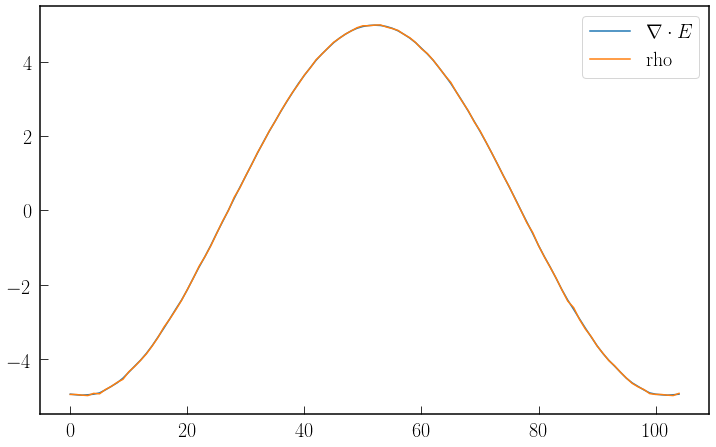

In [29]:
pl.plot(np.array(Divergence_E), label = r'$\nabla \cdot E$')
pl.plot(rho_initial , label = 'rho')
pl.legend()
pl.show()
pl.clf()

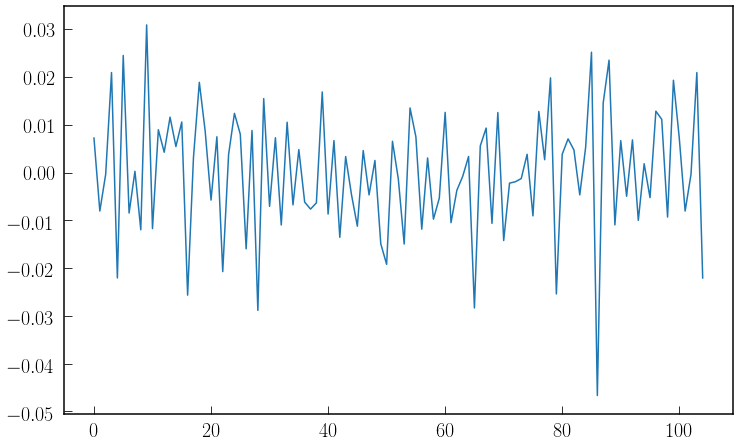

In [30]:
pl.plot(np.array(Divergence_E_rho))
pl.show()
pl.clf()

In [31]:
Ex_intitial_staggered = 0.5 * (Ex_initial_centered + np.roll(Ex_initial_centered, -1))
Ex_intitial_staggered = periodic_field(Ex_intitial_staggered, ghost_cells)

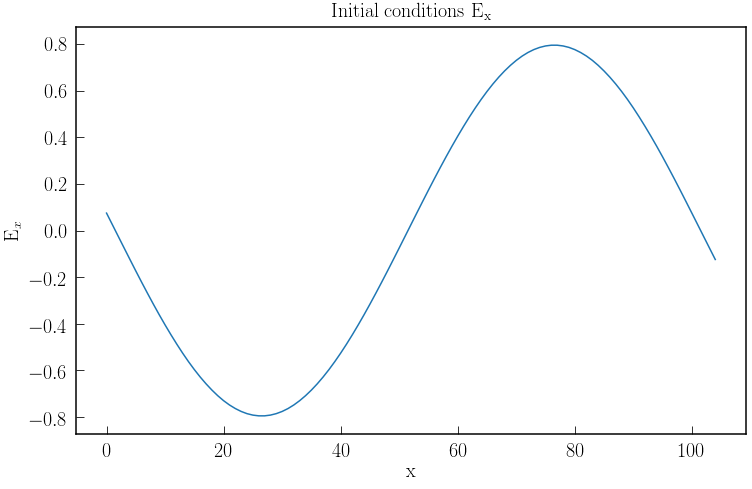

In [32]:
# Plotting the Electric field in the system for the given initial conditions
pl.plot(Ex_intitial_staggered, label = 'Ex numerical')
pl.xlabel('x')
pl.ylabel('E_{x}')
pl.title('$\mathrm{Initial\;conditions\;E_{x}}$')
pl.show()
pl.clf()

In [33]:
# Converting to arrayfire arrays
Ex           = af.to_array(Ex_intitial_staggered)
positions_x  = af.to_array(positions_x)
velocity_x   = af.to_array(velocity_x)
x_grid       = af.to_array(x_grid)
x_right      = af.to_array(x_right)

In [34]:
# This cell block is to obtain v at (t = 0.5dt) to implement the verlet algorithm.

positions_x_half = positions_x + velocity_x * dt/2

# Periodic Boundary conditions for particles 

positions_x_half = periodic_particles(positions_x_half, length_domain_x)

# Finding interpolant fractions for the positions

frac_interpolation = (positions_x_half - af.sum(x_right[0])) / dx

# Interpolating the fields at each particle
Ex_particle = af.signal.approx1(Ex, frac_interpolation, method= af.INTERP.LINEAR)


# Updating the velocity using the interpolated Electric fields to find v at (t = 0.5dt)

velocity_x = velocity_x  + (Ex_particle * charge_electron / mass_electron ) * dt/2

In [35]:
for time_index in range(len(time)):
    if(time_index%25==0):
        print('Computing for time = ', time_index * dt)

        
        

    # Updating the positions of particle using the velocites (Verlet algorithm)
    # velocity at t = (n + 1/2) dt, positions_x at t = (n)dt and positions_x_new 
    # at t = (n+1)dt
    positions_x_new = positions_x + velocity_x * dt
    
    # Periodic Boundary conditions for particles 
    positions_x_new = periodic_particles(positions_x_new, length_domain_x)

    # Computing the current densities on the staggered grid provided by Umeda's scheme
    
    Jx_staggered = Jx_Esirkepov( charge_electron, number_of_electrons, positions_x, velocity_x,\
                                  x_grid, ghost_cells,length_domain_x, dx, dt\
                                )
    
    # Normalizing and evaluation of current densities on the centered grid
    
    Jx_norm_staggered = current_norm_BC(Jx_staggered, number_of_electrons, w_p)
    
    # Evolving electric fields using currents
        
    Ex = Ex - Jx_norm_staggered * dt
    
    # Interpolating the fields at each particle
    # calculating the interpolation fraction needed for arrayfire's 1D interpolation
    frac_interpolation = (positions_x_new - af.sum(x_right[0])) / dx
    
    Ex_particle = af.signal.approx1(Ex, frac_interpolation, method= af.INTERP.CUBIC_SPLINE)
    
    # Updating the velocity using the interpolated Electric fields
    
    velocity_x_new = velocity_x  + (Ex_particle * charge_electron / mass_electron ) * dt
    
    # Saving the Electric fields for plotting
    
    Ex_max[time_index]       = (af.max(af.abs(Ex)))
    
    pl.plot(Ex[ghost_cells:-ghost_cells])
    pl.ylim(-1, 1)
    pl.savefig('images2/' + str(time_index) + '.png')
    pl.clf()
    

    # Saving the updated velocites for the next timestep
    velocity_x  = velocity_x_new.copy()
    positions_x = positions_x_new.copy()

Computing for time =  0.0
Jx_staggered is  arrayfire.Array()
Type: double
[105 1 1 1]
  541.9230 
3011205.3245 
3058962.0615 
16873.1076 
-53921.0012 
-309698.1861 
-164628.1979 
-371317.9633 
-84670.7432 
-123041.2196 
-520860.8471 
-414175.7600 
-304860.3627 
-13833.1464 
-135463.7509 
-273618.1297 
-534475.5410 
-807038.6150 
-659762.5343 
-502515.3514 
-700639.1701 
-592620.3041 
-700207.2613 
-510845.7016 
-534872.7210 
-589157.2691 
-409323.6961 
-429983.6136 
-84064.9748 
-266152.0462 
-345278.3574 
-103614.7025 
-350053.8205 
-478287.0196 
-380625.6517 
-156716.6661 
-254922.6163 
-319896.9356 
-239938.3913 
-237976.7506 
-128124.6195 
-138645.7082 
-269971.6224 
-316875.8850 
-194080.0706 
-225081.3080 
78715.1363 
49999.1861 
38023.1045 
-225049.9779 
-174552.7804 
-100500.9569 
-156977.1172 
-92058.5945 
-118389.6062 
100812.5760 
238828.4510 
421601.8061 
277549.6201 
128707.1360 
246162.9283 
72626.5359 
141280.3664 
-86797.9629 
350799.7759 
291655.2313 
198990.9268 
3072

In [36]:
# Reading data generated by the Cheng Knorr code
h5f = h5py.File('CK_256.h5', 'r')
Ex_max_CK = h5f['max_E'][:]
Ex_max_CK = np.abs(Ex_max_CK)
h5f.close()
time_CK = np.linspace(0,time[-1], len(Ex_max_CK))

In [37]:
# Reading data generated by the Cheng Knorr code
h5f = h5py.File('LT.h5', 'r')
Ex_max_LT = h5f['Ex_amp'][:]
Ex_max_LT = np.abs(Ex_max_LT)
time_LT   = h5f['time_LT'][:]
h5f.close()

In [44]:
time_grid = np.linspace(0, time[-1], len(Ex_max))
pl.plot(time_grid, Ex_max , label = r'$\mathrm{PIC}$')
# pl.plot(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.plot(time_CK, Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
# print('(abs(Ex_amplitude[0])) is ',(abs(Ex_amplitude[0])))
# print('(abs(Ex_max[0])) is ',(abs(Ex_max[0])))
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
pl.legend()
# pl.show()
pl.savefig('MaxE_LT.png')
pl.clf()

In [45]:
pl.semilogy(time_grid, Ex_max ,label = r'$\mathrm{PIC}$')
# pl.semilogy(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.semilogy(time_CK,Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
pl.legend()
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
# pl.show()
pl.savefig('MaxE_semilogy_LT.png')
pl.clf()

In [46]:
pl.loglog(time_grid, Ex_max ,label = r'$\mathrm{PIC}$')
# pl.loglog(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.semilogy(time_CK,Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
pl.legend()
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
# pl.show()
pl.savefig('MaxE_loglog_LT.png')
pl.clf()